# Finding the artist when given the painting


Full Report: https://drive.google.com/file/d/12beKneCiLydHPItlM_L7lN0rYtOzchbP/view?usp=sharing 

In [ ]:
#Imports
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from os import path
from keras.preprocessing.image import ImageDataGenerator
import keras.utils
from keras.models import Sequential, Model
from keras import datasets, layers, models
import keras.applications
from keras.layers import Dense,Flatten
from keras.models import Sequential
import pathlib





#tensor flowl, either keras or normal

In [ ]:
#only using the top 10 artists
artists = pd.read_csv('artists.csv')
artists = artists.sort_values(by=['paintings'], ascending=False)
topArtists = artists[artists['paintings'] >= 200].reset_index()
print(topArtists)
topArtists = topArtists[['name', 'paintings']]
topArtists = topArtists.sort_values('name')
print(topArtists)

#how we make sure not everything is the most seen painter, weighting painter based on num painters
#topArtists['class_weight'] = max(topArtists.paintings)/topArtists.paintings
#class_weights = topArtists['class_weight'].to_dict()
class_weights = topArtists.paintings.sum() / (topArtists.shape[0] * topArtists.paintings)
class_weights = class_weights.to_dict()

#might fix this  homie: Albrecht_Dürer
updated_name = "Albrecht_Dürer".replace("_", " ")
topArtists.iloc[0, 0] = updated_name
print(class_weights)
print(topArtists)

    index  id                   name        years  \
0       8   8       Vincent van Gogh  1853 – 1890   
1      30  30            Edgar Degas  1834 - 1917   
2      13  13          Pablo Picasso  1881 - 1973   
3      15  15  Pierre-Auguste Renoir  1841 - 1919   
4      19  19         Albrecht Dürer  1471 - 1528   
5      46  46           Paul Gauguin  1848 – 1903   
6      16  16         Francisco Goya  1746 - 1828   
7      31  31              Rembrandt  1606 - 1669   
8      20  20          Alfred Sisley  1839 - 1899   
9      32  32                 Titian  1488 - 1576   
10     22  22           Marc Chagall  1887 - 1985   

                           genre               nationality  \
0             Post-Impressionism                     Dutch   
1                  Impressionism                    French   
2                         Cubism                   Spanish   
3                  Impressionism                    French   
4           Northern Renaissance                    G

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/sam_tylerbrr/resized/resized'
images_dir = os.listdir('/content/gdrive/MyDrive/sam_tylerbrr/resized/resized')
topArtistsNames = topArtists['name'].str.replace(' ', '_').values

In [ ]:
print(topArtistsNames)
print(images_dir)
artists_top_name = topArtists['name'].str.replace(' ', '_').values
print(artists_top_name)

['Albrecht_Dürer' 'Alfred_Sisley' 'Edgar_Degas' 'Francisco_Goya'
 'Marc_Chagall' 'Pablo_Picasso' 'Paul_Gauguin' 'Pierre-Auguste_Renoir'
 'Rembrandt' 'Titian' 'Vincent_van_Gogh']
['Albrecht_Dürer', 'Vincent_van_Gogh', 'Titian', 'Alfred_Sisley', 'Rembrandt', 'Edgar_Degas', 'Francisco_Goya', 'Marc_Chagall', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']
['Albrecht_Dürer' 'Alfred_Sisley' 'Edgar_Degas' 'Francisco_Goya'
 'Marc_Chagall' 'Pablo_Picasso' 'Paul_Gauguin' 'Pierre-Auguste_Renoir'
 'Rembrandt' 'Titian' 'Vincent_van_Gogh']


In [ ]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = topArtists.shape[0]
allData = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(224,224))
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   #rescale=1./255.,
                                   #shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
train_generator = train_datagen.flow_from_directory(directory=path,
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    target_size=train_input_shape[0:2],
                                                    shuffle=True,
                                                    #classes=artists_top_name.tolist()
                                                   )
valid_generator = train_datagen.flow_from_directory(directory=path,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    #classes=artists_top_name.tolist()
                                                   )
trainData = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=432,
    image_size=(224,224),
    batch_size=16
    #class_names = artists_top_name.tolist()
    )
testData = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=432,
    image_size=(224,224),
    batch_size=16
    #class_names = artists_top_name.tolist()
    )

print(valid_generator.class_indices)


Found 4306 files belonging to 11 classes.
Found 3448 images belonging to 11 classes.
Found 858 images belonging to 11 classes.
Found 4306 files belonging to 11 classes.
Using 3445 files for training.
Found 4306 files belonging to 11 classes.
Using 861 files for validation.
{'Albrecht_Dürer': 0, 'Alfred_Sisley': 1, 'Edgar_Degas': 2, 'Francisco_Goya': 3, 'Marc_Chagall': 4, 'Pablo_Picasso': 5, 'Paul_Gauguin': 6, 'Pierre-Auguste_Renoir': 7, 'Rembrandt': 8, 'Titian': 9, 'Vincent_van_Gogh': 10}


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape = train_input_shape),
    #keras.layers.Dropout(.2),
    #keras.layers.Flatten(),
    #keras.layers.MaxPooling2D(),
    # keras.layers.Conv2D(32,(2,2),activation='relu'),
    #keras.layers.Conv2D(128,(2,2),activation='relu'),
    #keras.layers.MaxPooling2D(),
    #keras.layers.Conv2D(128,(2,2),activation='sigmoid'),
    #keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    #keras.layers.Dense(50, activation='sigmoid'),
    keras.layers.Dense(11, activation='sigmoid'),
])
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)
modelCNNHistory = model.fit(trainData, epochs=4, validation_data=testData, callbacks=callback,class_weight=class_weights)

Epoch 1/4


KeyboardInterrupt: ignored

In [ ]:
from pandas.core.common import flatten
#trying resnet
modelRes = Sequential()
ResNetModel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',
                   weights='imagenet',classes = 1000)
for layer in ResNetModel.layers:
  layer.trainable=False
modelRes.add(ResNetModel)
modelRes.add(Flatten())
modelRes.add(Dense(11,activation='sigmoid'))
modelRes.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
resModelHistory = modelRes.fit(trainData, validation_data=testData, epochs=10,class_weight=class_weights)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
216/216 [==============================] - 702s 3s/step - loss: 5.3348 - accuracy: 0.4711 - val_loss: 3.6914 - val_accuracy: 0.5621
Epoch 2/10
216/216 [==============================] - 647s 3s/step - loss: 2.4207 - accuracy: 0.7030 - val_loss: 2.2981 - val_accuracy: 0.6620
Epoch 3/10
216/216 [==============================] - 664s 3s/step - loss: 1.5680 - accuracy: 0.7721 - val_loss: 2.5631 - val_accuracy: 0.6887
Epoch 4/10
216/216 [==============================] - 682s 3s/step - loss: 1.3134 - accuracy: 0.8148 - val_loss: 2.1391 - val_accuracy: 0.7166
Epoch 5/10
Epoch 5/10
Epoch 5/10
216/216 [==============================] - 677s 3s/step - loss: 0.7704 - accuracy: 0.8612 - val_loss: 2.3302 - val_accuracy: 0.7085
Epoch 6/10
Epoch 6/10
Epoch 6/10
216/216 [==============================] - 676s 3s/step - loss: 0.6071 - accuracy: 0.8842 - val_loss: 2.4705 - val_accuracy: 0.6957
Epoch 7/10
Epoch 7/10
Epoch 7/10


In [ ]:
modelRes2 = Sequential()
ResNetModel2= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),pooling='max',
                   weights='imagenet')
for layer in ResNetModel2.layers:
        layer.trainable=False
modelRes2.add(ResNetModel2)
modelRes2.add(Flatten())
modelRes2.add(Dense(512, activation='relu'))
modelRes2.add(Dense(169, activation='relu'))
modelRes2.add(Dense(11, activation='sigmoid'))
modelRes2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
resModel2History = modelRes2.fit(train_generator, validation_data=valid_generator, epochs=10,class_weight=class_weights)

Epoch 1/10
216/216 [==============================] - 810s 4s/step - loss: 2.4166 - accuracy: 0.1450 - val_loss: 2.1785 - val_accuracy: 0.1923
Epoch 2/10
216/216 [==============================] - 841s 4s/step - loss: 2.1804 - accuracy: 0.1847 - val_loss: 2.2052 - val_accuracy: 0.2133
Epoch 3/10
216/216 [==============================] - 800s 4s/step - loss: 2.0842 - accuracy: 0.2143 - val_loss: 2.2318 - val_accuracy: 0.1550
Epoch 4/10
216/216 [==============================] - 806s 4s/step - loss: 1.9916 - accuracy: 0.2407 - val_loss: 1.9043 - val_accuracy: 0.2984
Epoch 5/10
216/216 [==============================] - 802s 4s/step - loss: 1.9332 - accuracy: 0.2662 - val_loss: 1.8606 - val_accuracy: 0.2949
Epoch 6/10
216/216 [==============================] - 795s 4s/step - loss: 1.8493 - accuracy: 0.2944 - val_loss: 1.7760 - val_accuracy: 0.3590
Epoch 7/10
216/216 [==============================] - 797s 4s/step - loss: 1.8244 - accuracy: 0.3010 - val_loss: 1.8842 - val_accuracy: 0.3030

In [ ]:
modelRes3 = Sequential()
ResNetModel3= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=11,
                   weights='imagenet')
for layer in ResNetModel3.layers:
        layer.trainable=False
modelRes3.add(ResNetModel3)
modelRes3.add(Flatten())
modelRes3.add(Dense(512, activation='relu'))
modelRes3.add(Dense(225, activation = 'relu'))
modelRes3.add(Dense(11, activation='sigmoid'))
modelRes3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
resModel3History = modelRes3.fit(trainData, validation_data=testData, epochs=10,class_weight=class_weights)

In [ ]:
#testing the model
#testAgain = tf.data.Dataset.sample_from_datasets(allData,
testData1 = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',
    validation_split=.1,
    subset='validation',
    seed=9393,
    image_size=(224,224),
    batch_size=16)
model.evaluate(testData1)
modelRes.evaluate(testData1)
modelRes2.evaluate(testData1)
modelRes3.evaluate(testData1)
#30% accuracy on testData



Found 4306 files belonging to 11 classes.
Using 430 files for validation.
27/27 [==============================] - 69s 2s/step - loss: 0.4074 - accuracy: 0.9093


[0.4074100852012634, 0.9093023538589478]

In [ ]:
#save models
model_path = '/content/gdrive/MyDrive/sam_tylerbrr/savedModels/model1'
modelRes_path = '/content/gdrive/MyDrive/sam_tylerbrr/savedModels/model2'
modelRes2_path = '/content/gdrive/MyDrive/sam_tylerbrr/savedModels/model3'
modelRes3_path = '/content/gdrive/MyDrive/sam_tylerbrr/savedModels/model4'
#model.save(model_path)
#modelRes.save(modelRes_path)
#modelRes2.save(modelRes2_path)
#modelRes3.save(modelRes3_path)


In [ ]:
#load
model = keras.models.load_model(model_path)
modelRes = keras.models.load_model(modelRes_path)
modelRes2 = keras.models.load_model(modelRes2_path)
modelRes3 = keras.models.load_model(modelRes3_path)

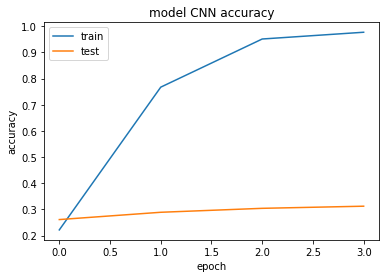

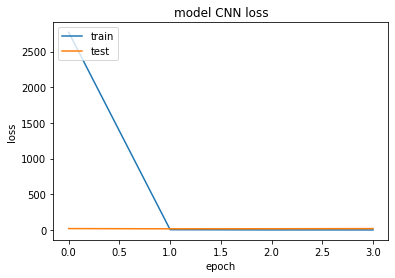

In [ ]:
#display Graphs
#first Model
plt.plot(modelCNNHistory.history['accuracy'])
plt.plot(modelCNNHistory.history['val_accuracy'])
plt.title('model CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(modelCNNHistory.history['loss'])
plt.plot(modelCNNHistory.history['val_loss'])
plt.title('model CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


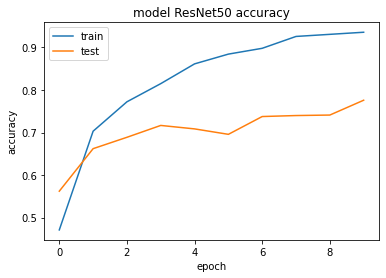

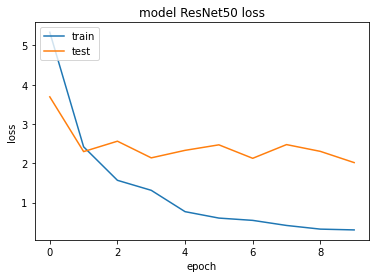

In [ ]:
#second Model
plt.plot(resModelHistory.history['accuracy'])
plt.plot(resModelHistory.history['val_accuracy'])
plt.title('model ResNet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(resModelHistory.history['loss'])
plt.plot(resModelHistory.history['val_loss'])
plt.title('model ResNet50 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
#third model
plt.plot(resModel2History.history['accuracy'])
plt.plot(resModel2History.history['val_accuracy'])
plt.title('model ResNet50 accuracy withh image processing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(resModel2History.history['loss'])
plt.plot(resModel2History.history['val_loss'])
plt.title('model ResNet50 loss with image processing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


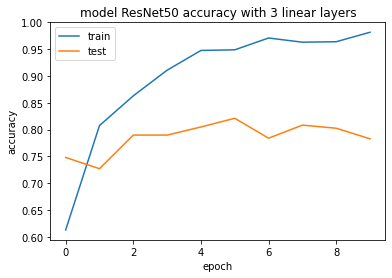

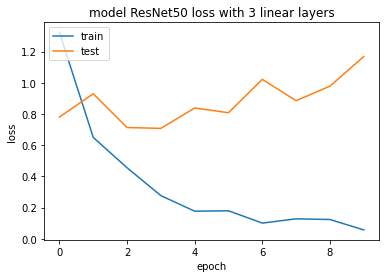

In [ ]:
#fourth model
plt.plot(resModel3History.history['accuracy'])
plt.plot(resModel3History.history['val_accuracy'])
plt.title('model ResNet50 accuracy with 3 linear layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(resModel3History.history['loss'])
plt.plot(resModel3History.history['val_loss'])
plt.title('model ResNet50 loss with 3 linear layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

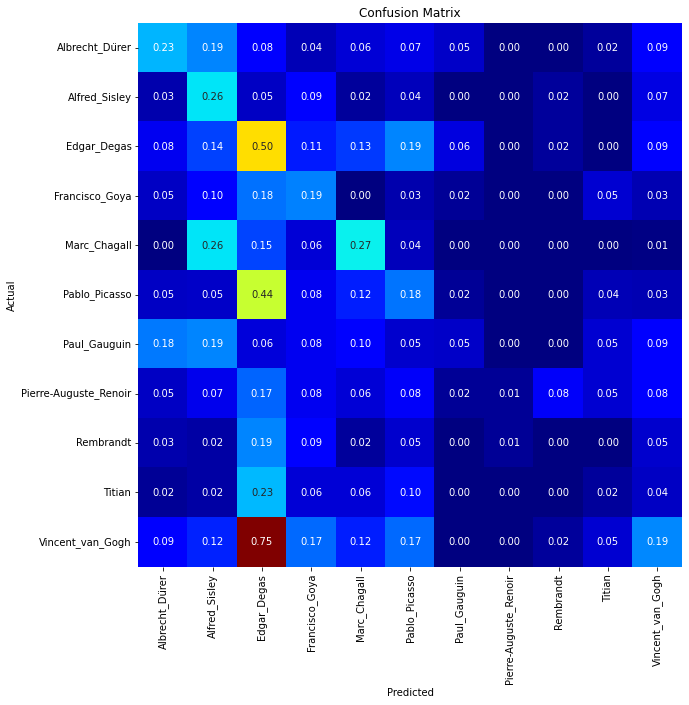

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.29      0.23      0.25        66
        Alfred_Sisley       0.18      0.26      0.22        42
          Edgar_Degas       0.18      0.50      0.27       131
       Francisco_Goya       0.18      0.19      0.19        53
         Marc_Chagall       0.29      0.27      0.28        52
        Pablo_Picasso       0.18      0.18      0.18       100
         Paul_Gauguin       0.23      0.05      0.08        64
Pierre-Auguste_Renoir       0.50      0.01      0.03        67
            Rembrandt       0.00      0.00      0.00        49
               Titian       0.06      0.02      0.03        57
     Vincent_van_Gogh       0.25      0.19      0.22       180

             accuracy                           0.20       861
            macro avg       0.21      0.17      0.16       861
         weighted avg       0.22      0.20      0.17       861



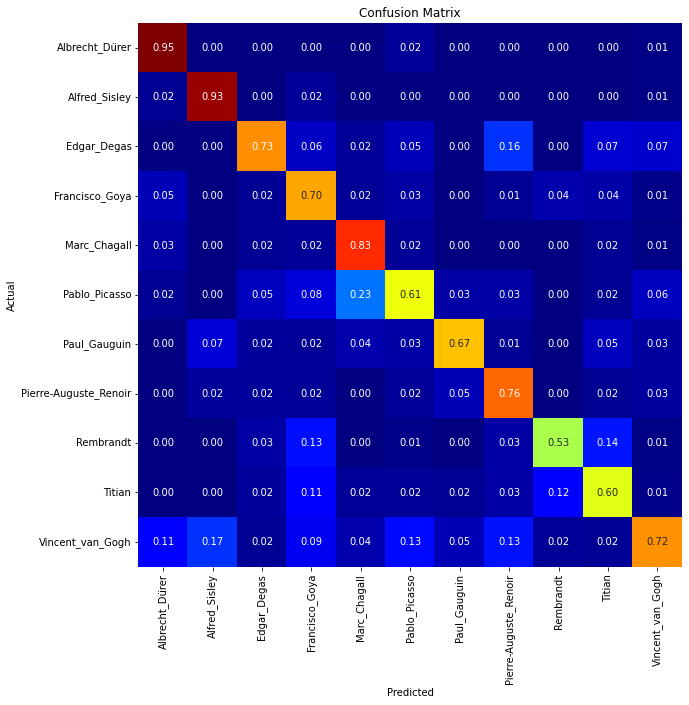

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.82      0.95      0.88        66
        Alfred_Sisley       0.78      0.93      0.85        42
          Edgar_Degas       0.79      0.73      0.75       131
       Francisco_Goya       0.56      0.70      0.62        53
         Marc_Chagall       0.69      0.83      0.75        52
        Pablo_Picasso       0.65      0.61      0.63       100
         Paul_Gauguin       0.83      0.67      0.74        64
Pierre-Auguste_Renoir       0.65      0.76      0.70        67
            Rembrandt       0.74      0.53      0.62        49
               Titian       0.62      0.60      0.61        57
     Vincent_van_Gogh       0.76      0.72      0.74       180

             accuracy                           0.72       861
            macro avg       0.72      0.73      0.72       861
         weighted avg       0.73      0.72      0.72       861



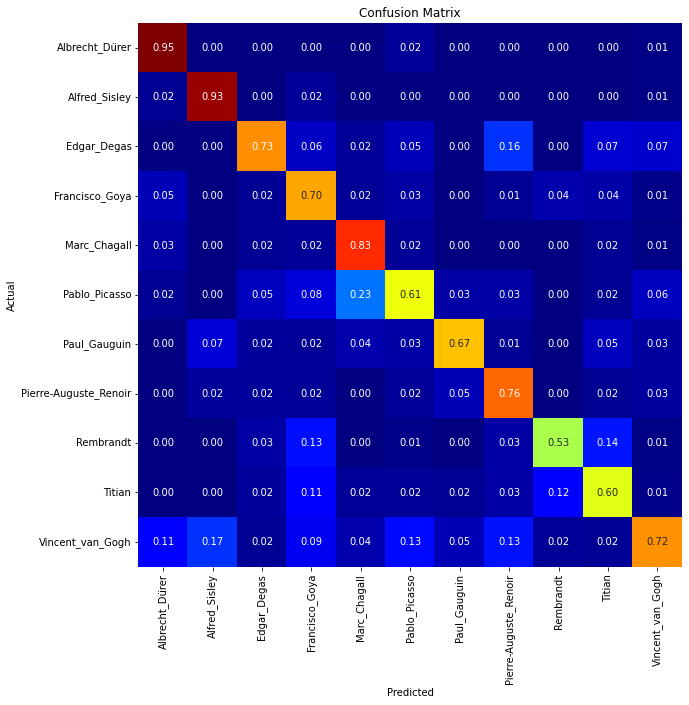

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.82      0.95      0.88        66
        Alfred_Sisley       0.78      0.93      0.85        42
          Edgar_Degas       0.79      0.73      0.75       131
       Francisco_Goya       0.56      0.70      0.62        53
         Marc_Chagall       0.69      0.83      0.75        52
        Pablo_Picasso       0.65      0.61      0.63       100
         Paul_Gauguin       0.83      0.67      0.74        64
Pierre-Auguste_Renoir       0.65      0.76      0.70        67
            Rembrandt       0.74      0.53      0.62        49
               Titian       0.62      0.60      0.61        57
     Vincent_van_Gogh       0.76      0.72      0.74       180

             accuracy                           0.72       861
            macro avg       0.72      0.73      0.72       861
         weighted avg       0.73      0.72      0.72       861



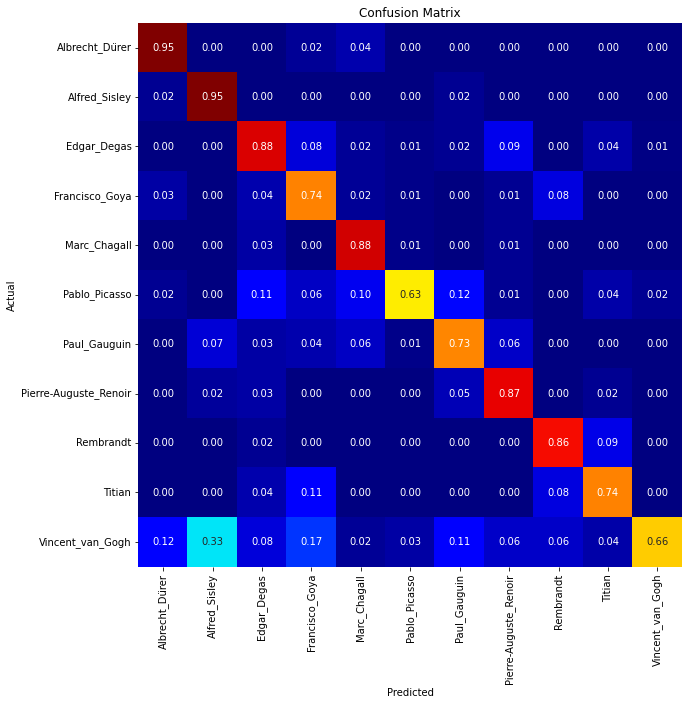

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.84      0.95      0.89        66
        Alfred_Sisley       0.69      0.95      0.80        42
          Edgar_Degas       0.71      0.88      0.78       131
       Francisco_Goya       0.61      0.74      0.67        53
         Marc_Chagall       0.78      0.88      0.83        52
        Pablo_Picasso       0.90      0.63      0.74       100
         Paul_Gauguin       0.70      0.73      0.72        64
Pierre-Auguste_Renoir       0.77      0.87      0.82        67
            Rembrandt       0.79      0.86      0.82        49
               Titian       0.78      0.74      0.76        57
     Vincent_van_Gogh       0.97      0.66      0.79       180

             accuracy                           0.78       861
            macro avg       0.78      0.81      0.78       861
         weighted avg       0.81      0.78      0.78       861



In [ ]:
#confusion matrix diagram
#step can be ceiling of number of images divided by batch size 
from sklearn.metrics import *
import seaborn as sns
artist_labels = artists_top_name.tolist()
def effectiveClassification(model, data, step):
  yHat, label = [],[]
  data = iter(data)
  for i in range(step):
    (X,y) = next(data)
    yHat.append(model.predict(X))
    label.append(y)
  yHat = [subresult for result in yHat for subresult in result]
  label = [subresult for result in label for subresult in result]
  label = np.argmax(label, axis=1)
  label = np.asarray(label).ravel()
  yHat = np.argmax(yHat, axis=1)
  yHat = np.asarray(yHat).ravel()
  fig, ax = plt.subplots(figsize=(10,10))
  conf_matrix = confusion_matrix(label, yHat, labels=np.arange(n_classes))
  conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
  sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=artist_labels, yticklabels=artist_labels,
                ax=ax)
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  plt.show()
  print('Classification Report:')
  print(classification_report(label, yHat, labels=np.arange(n_classes), target_names=artist_labels))
effectiveClassification(model,testData, testData.__len__())
effectiveClassification(modelRes,testData, testData.__len__())
effectiveClassification(modelRes2,testData, testData.__len__())
effectiveClassification(modelRes3,testData, testData.__len__())

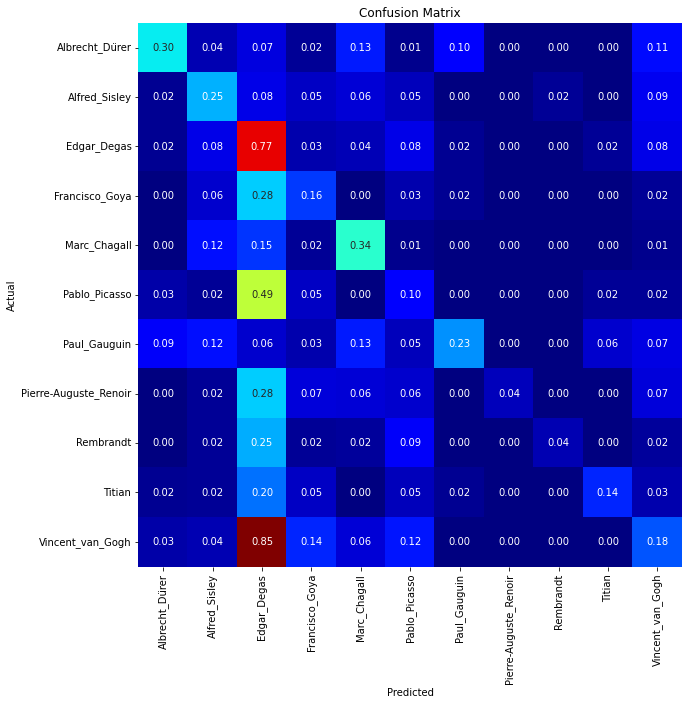

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.61      0.30      0.40        66
        Alfred_Sisley       0.33      0.25      0.29        51
          Edgar_Degas       0.22      0.77      0.34       140
       Francisco_Goya       0.24      0.16      0.19        58
         Marc_Chagall       0.40      0.34      0.37        47
        Pablo_Picasso       0.16      0.10      0.12        88
         Paul_Gauguin       0.61      0.23      0.33        62
Pierre-Auguste_Renoir       1.00      0.04      0.09        67
            Rembrandt       0.67      0.04      0.07        52
               Titian       0.58      0.14      0.22        51
     Vincent_van_Gogh       0.25      0.18      0.21       176

             accuracy                           0.27       858
            macro avg       0.46      0.23      0.24       858
         weighted avg       0.41      0.27      0.24       858



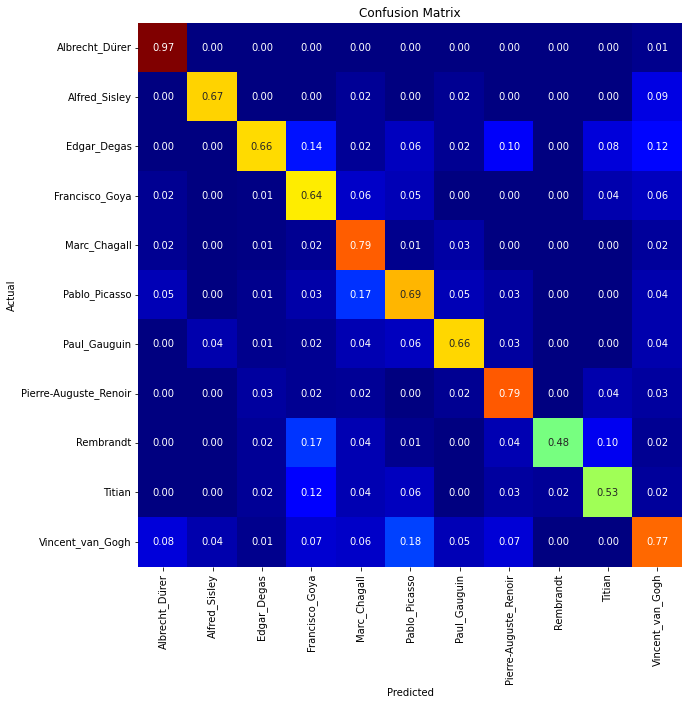

Classification Report:
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.86      0.97      0.91        66
        Alfred_Sisley       0.89      0.67      0.76        51
          Edgar_Degas       0.84      0.66      0.74       140
       Francisco_Goya       0.52      0.64      0.57        58
         Marc_Chagall       0.62      0.79      0.69        47
        Pablo_Picasso       0.62      0.69      0.66        88
         Paul_Gauguin       0.79      0.66      0.72        62
Pierre-Auguste_Renoir       0.72      0.79      0.75        67
            Rembrandt       0.96      0.48      0.64        52
               Titian       0.68      0.53      0.59        51
     Vincent_van_Gogh       0.63      0.77      0.70       176

             accuracy                           0.71       858
            macro avg       0.74      0.70      0.70       858
         weighted avg       0.73      0.71      0.71       858



KeyboardInterrupt: ignored

In [ ]:
effectiveClassification(model,valid_generator, valid_generator.__len__())
effectiveClassification(modelRes,valid_generator, valid_generator.__len__())
effectiveClassification(modelRes,valid_generator, valid_generator.__len__())
effectiveClassification(modelRes3,valid_generator, valid_generator.__len__())

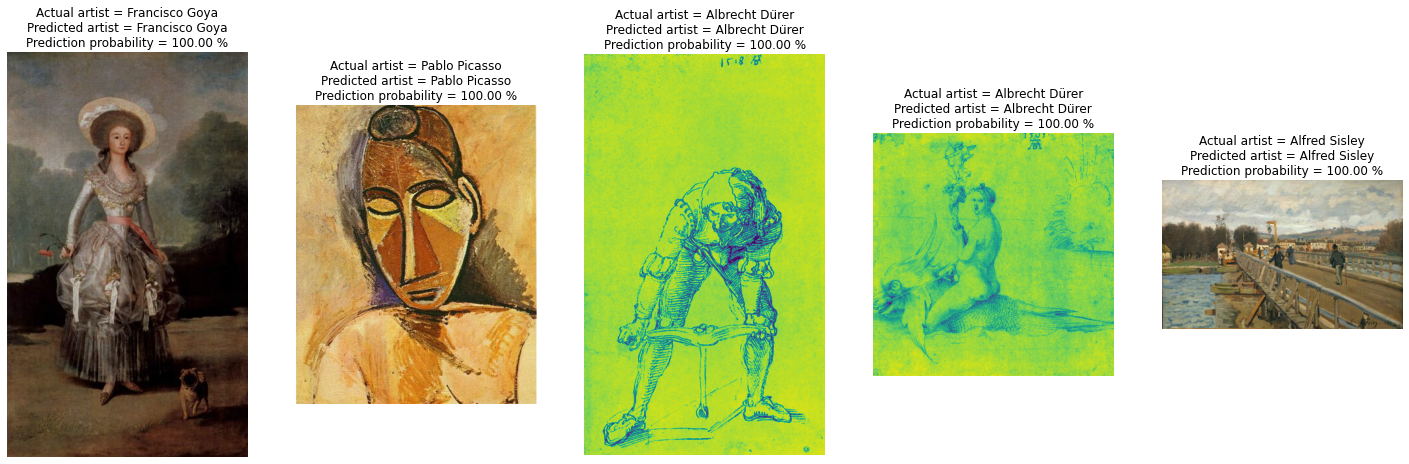

In [ ]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(topArtistsNames)
    random_image = random.choice(os.listdir(os.path.join(path, random_artist)))
    random_image_file = os.path.join(path, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(224,224))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    prediction = modelRes3.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = testData.class_names
    labels = dict(enumerate(labels))

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

Predicted artist = Albrecht Dürer
Prediction probability = 100.0 %


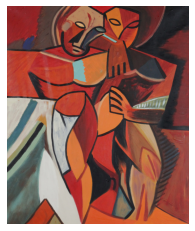

In [ ]:
#input image and then output name
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = 'https://media.overstockart.com/data/product_images/PS56920X24.jpg'

import imageio
import cv2
artist_labels = artists_top_name.tolist()
web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = np.expand_dims(web_image, axis=0)


prediction = modelRes2.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", artist_labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

In [ ]:
model.summary()
modelRes.summary()
modelRes3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 flatten_2 (Flatten)         (None, 3154176)           0         
                                                                 
 dense_6 (Dense)             (None, 11)                34695947  
                                                                 
Total params: 34,697,739
Trainable params: 34,697,739
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)    

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('sam_tyler_go_burr.ipynb')

--2022-07-20 13:07:29--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-07-20 13:07:29 (26.5 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/sam_tyler_go_burr.ipynb to pdf
[NbConvertApp] Writing 53893 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'